<a href="https://colab.research.google.com/github/qkd8059/Capstone/blob/main/Back_Test_with_Target_Return_and_Test_Regime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/qkd8059/Capstone.git

fatal: destination path 'Capstone' already exists and is not an empty directory.


In [ ]:
!pip install dnspython
!pip install hmmlearn

In [ ]:
from database_main import Database
from factor_main import *

In [2]:
data = factors_fit.read_asset('SP500Price')
factors = RegimeSwitching.read_factor(start_date = '2005-09-30')
market_factor = RegimeSwitching.get_marketfactor(factors)
latent_state = RegimeSwitching.hmm_fit(np.array(market_factor).reshape(-1,1))
regimes = RegimeSwitching.thresholding_regime(latent_state, 5)
factors = RegimeSwitching.combine(factors,regimes)
price_table, return_matrix = factors_fit.asset_return(data)
[asset_return,factors_return,corresponding_regime] = factors_fit.factors_and_returns(return_matrix,factors)
excess_return = factors_fit.get_excess_return(asset_return,factors_return)

In [3]:
from mvo import *
from mvo_cost import *
from cvar import *
from cvar_cost import *
from robust_cvar import *
from robust_cvar_cost import *
from max_sharpe import *
from max_sharpe_cost import *
from risk_parity import *
from risk_parity_cost import *


#Back-Testing with Target Return

In [4]:

class backtest_bull (object):
# card = 10
# regime_flag = 0
# regime_flag = 1
# model_flag = 0
# model_flag = 1
# model_flag = 2
# model_flag = 3
# model_flag = 4
# cost_flag = 0
# cost_flag = 1
# date = ['2010-10-15']
# price_table = df
  def cardinality (principal):
    if principal <= 10000:
      card = 5
    elif principal > 10000 and principal <= 100000:
      card = 5
    else: card = 12
    return card
  def choose_model (regime_flag):
    if regime_flag == 0:
      model_flag = 1
      cost_flag = 0
    else:
      model_flag = 1
      cost_flag = 1
    return model_flag, cost_flag
  def get_weight (mu, Q, card, price_table, date, old_weight, old_ticker, model_flag, cost_flag, target_return):
    opt_model = [[mvo,mvo_cost],[cvar,cvar_cost],[robust_cvar,robust_cvar_cost],
                [max_sharpe, max_sharpe_cost],[risk_parity, risk_parity_cost]]
    if model_flag == 1 or model_flag == 2:
      if cost_flag == 0:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q,card,price_table,date,target_return)
      else:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q, card, price_table, date, old_weight, old_ticker,target_return)
    else:
      if cost_flag == 0:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q,card)
      else:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q, card, old_weight, old_ticker)
    return weight, ticker_index

  def multiperiod (factors_return, excess_return, df, lookback, principal,regime_flag,model_flag, cost_flag,target_return):
    weight = []
    ticker_index = []
    mu_all = []
    card = backtest_bull.cardinality(principal)
    #model_flag, cost_flag = optimization.choose_model(regime_flag)
    #print(len(factors_return))
    if len(factors_return) % lookback != 0:
      factors_return = factors_return[:-int(len(factors_return) % lookback)]
    #print(len(factors_return))
    for i in range(int(len(factors_return)/lookback)):
      mu, Q = factors_fit.generate_factor(factors_return[0:(i+1)*lookback],excess_return[0:(i+1)*lookback])
      #print(len(Q))
      if i == 0:
        old_weight = np.zeros(card)
        old_ticker = np.arange(card)
      else:
        old_weight = weight[i-1]
        old_ticker = ticker_index[i-1]
      mu_all.append(mu)
      weight.append(backtest_bull.get_weight(mu,Q,card, df, df.columns.values[(i+1)*lookback], old_weight, old_ticker, model_flag, cost_flag,target_return)[0])
      ticker_index.append(backtest_bull.get_weight(mu,Q,card, df, df.columns.values[(i+1)*lookback], old_weight, old_ticker, model_flag, cost_flag,target_return)[1])
    return mu_all, weight, ticker_index
  
  def get_port_info (mu,Q,weight,ticker,date_list):
    all_weight = []
    all_ticker = []
    all_exp_return = []
    all_actual_return = []
    all_port_exp_ret = []
    all_port_act_ret = []
    for i in range(len(date_list)-2):
      cur_date = df.columns.values[date_list[i]]
      # exp_return = mu[ticker[i]]
      exp_return = mu[i][ticker[i]]
      actual_return = df.iloc[ticker[i],date_list[i+2]].values/df.iloc[ticker[i],date_list[i+1]].values
      port_exp_return = lookback*sum(weight[i]*exp_return)
      port_actual_return = sum(weight[i]*actual_return)-1
      all_weight.append(weight[i])
      all_ticker.append(ticker[i])
      all_exp_return.append(exp_return)
      all_actual_return.append(actual_return)
      all_port_exp_ret.append(port_exp_return)
      all_port_act_ret.append(port_actual_return)
    return all_weight, all_ticker, all_exp_return, all_actual_return, all_port_exp_ret, all_port_act_ret

  ### Calculate expected and actual cumulative return
  def cum_return (port_ret):
    cal_ret_list = []
    cum_ret_list = []
    for i in range(len(port_ret)):
      cal_ret_list.append(port_ret[i]+1)
    ret = 1
    for num in cal_ret_list:
      ret = ret*num
      cum_ret_list.append(ret)
    return cum_ret_list

  # calculate the mean difference between actual and expected return
  def mean_diff (act_ret,exp_ret):
    diff_list = np.asarray(act_ret) - np.asarray(exp_ret)
    return diff_list.mean()

  def sharpe_ratio (act_ret,exp_ret,rf):
    act_std = np.std(act_ret)
    exp_std = np.std(exp_ret)
    act_sr = (np.subtract(act_ret,rf))/act_std
    exp_sr = (np.subtract(exp_ret,rf))/exp_std
    return act_sr, exp_sr

  def get_cum_ret(date_list,model_flag,lookback,cost_flag,target_return):
    cost_flag = 0
    mu_all, w, t = backtest_bull.multiperiod (factors_return[542:629], excess_return[542:629], df=price_table, lookback = lookback, principal = 20000,regime_flag = 0,model_flag = model_flag, cost_flag = cost_flag,target_return = target_return)
    #print(mu_all[1][t[1]])
    all_weight, all_ticker, all_exp_return, all_actual_return, all_port_exp_ret, all_port_act_ret = backtest_bull.get_port_info (mu=mu_all,Q=None,weight=w,ticker=t,date_list=date_list)
    # mu_all[0][ticker[1]]
    # print(all_port_act_ret)
    cum_ret_exp = backtest_bull.cum_return(all_port_exp_ret)
    cum_ret_act = backtest_bull.cum_return(all_port_act_ret)
    return all_weight, all_ticker, cum_ret_exp,cum_ret_act

In [ ]:
lookback = 5
df = price_table
date_list = np.arange(542,629,lookback)
target_return = 0.25
target_return_period = target_return * lookback/52
rCVAR_cum_ret_exp,rCVAR_cum_ret_act=backtest_bull.get_cum_ret(date_list,2,lookback,cost_flag,target_return_period)
print("Robust CVAR DONE")
CVAR_cum_ret_exp,CVAR_cum_ret_act=backtest_bull.get_cum_ret(date_list,1,lookback,cost_flag,target_return_period)
print("CVAR DONE")
MVO_cum_ret_exp,MVO_cum_ret_act=backtest_bull.get_cum_ret(date_list,0,lookback,target_return_period)
print("MVO DONE")
# Sharpe_cum_ret_exp,Sharpe_cum_ret_act=backtest_bull.get_cum_ret(date_list,3,lookback)
# print("Sharpe DONE")
# RP_cum_ret_exp,RP_cum_ret_act=backtest_bull.get_cum_ret(date_list,4,lookback)
# print("RP DONE")
MVO_cum_ret_act.insert(0,1)
rCVAR_cum_ret_act.insert(0,1)
CVAR_cum_ret_act.insert(0,1)
# Sharpe_cum_ret_act.insert(0,1)
# RP_cum_ret_act.insert(0,1)

In [ ]:
!pip install yfinance
import yfinance as yf
start_date = '2016-03-04'
end_date = '2017-10-20'
data = yf.download("SPY", start=start_date, end=end_date)
print(data[:]['Adj Close'])
SPY_price = data[:]['Adj Close']
SPY_price = SPY_price[0:len(SPY_price):23]
SPY_return = SPY_price.pct_change().dropna()
SPY_return = SPY_return.values.tolist()
SPY_act_return = []
base = 1
for i in range(len(SPY_return)):
  if i == 0:
    SPY_act_return.append(base)
  else:
    SPY_act_return.append(SPY_act_return[i-1]*(1+SPY_return[i]))

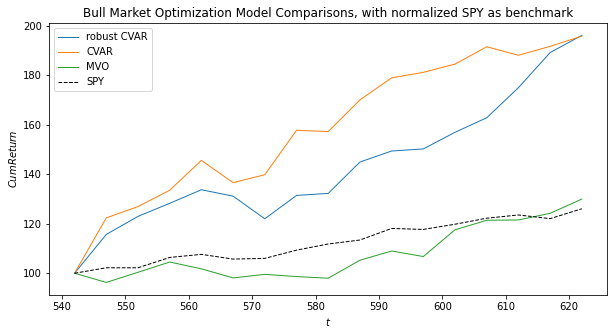

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(date_list[:-1], np.asarray(rCVAR_cum_ret_act)*100, linewidth=1)    #Using 95% VaR, 1000 times simulation, theta = 1.96
plt.plot(date_list[:-1], np.asarray(CVAR_cum_ret_act)*100, linewidth=1)     #Using 95% VaR, 1000 times simulation,
plt.plot(date_list[:-1], np.asarray(MVO_cum_ret_act)*100, linewidth=1)
plt.plot(date_list[:-1],np.asarray(SPY_act_return)*100, 'k--',linewidth = 1)    #Use SPY, a S&P 500 tracking ETF as benchmark
# plt.plot(date_list[:-1], np.asarray(Sharpe_cum_ret_act)*100, linewidth=1)
# plt.plot(date_list[:-1], np.asarray(RP_cum_ret_act)*100, linewidth=1)
plt.legend(['robust CVAR','CVAR','MVO','SPY'])
plt.xlabel('$t$')
plt.ylabel('$Cum Return$')
plt.title('Bull Market Optimization Model Comparisons, with normalized SPY as benchmark')
plt.show()

In [ ]:
lookback = 5
df = price_table
date_list = np.arange(542,629,lookback)
target_return = 0.25
target_return_period = target_return * lookback/52
cost_flag = 1
rCVAR_all_weight, rCVAR_all_ticker, rCVAR_cum_ret_exp,rCVAR_cum_ret_act=backtest_bull.get_cum_ret(date_list,2,lookback,cost_flag,target_return_period)
print("Robust CVAR DONE")
CVAR_all_weight, CVAR_all_ticker,CVAR_cum_ret_exp,CVAR_cum_ret_act=backtest_bull.get_cum_ret(date_list,1,lookback,cost_flag,target_return_period)
print("CVAR DONE")
MVO_all_weight, MVO_all_ticker,MVO_cum_ret_exp,MVO_cum_ret_act=backtest_bull.get_cum_ret(date_list,0,lookback,cost_flag,target_return_period)
print("MVO DONE")
# Sharpe_cum_ret_exp,Sharpe_cum_ret_act=backtest_bull.get_cum_ret(date_list,3,lookback)
# print("Sharpe DONE")
# RP_cum_ret_exp,RP_cum_ret_act=backtest_bull.get_cum_ret(date_list,4,lookback)
# print("RP DONE")
MVO_cum_ret_act.insert(0,1)
rCVAR_cum_ret_act.insert(0,1)
CVAR_cum_ret_act.insert(0,1)

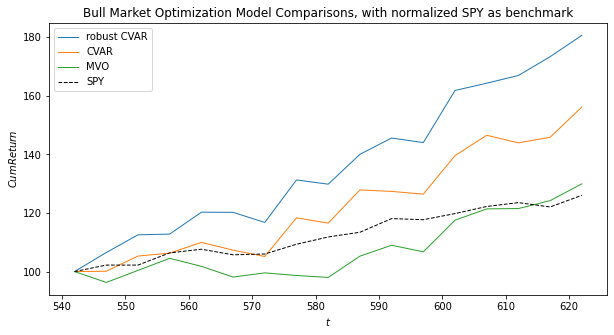

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(date_list[:-1], np.asarray(rCVAR_cum_ret_act)*100, linewidth=1)    #Using 95% VaR, 1000 times simulation, theta = 1.96
plt.plot(date_list[:-1], np.asarray(CVAR_cum_ret_act)*100, linewidth=1)     #Using 95% VaR, 1000 times simulation,
plt.plot(date_list[:-1], np.asarray(MVO_cum_ret_act)*100, linewidth=1)
plt.plot(date_list[:-1],np.asarray(SPY_act_return)*100, 'k--',linewidth = 1)    #Use SPY, a S&P 500 tracking ETF as benchmark
# plt.plot(date_list[:-1], np.asarray(Sharpe_cum_ret_act)*100, linewidth=1)
# plt.plot(date_list[:-1], np.asarray(RP_cum_ret_act)*100, linewidth=1)
plt.legend(['robust CVAR','CVAR','MVO','SPY'])
plt.xlabel('$t$')
plt.ylabel('$Cum Return$')
plt.title('Bull Market Optimization Model Comparisons, with normalized SPY as benchmark')
plt.show()

[0.17693362142579888, 0.17802044974559464, 0.19133086936169327, 0.20474104002130505, 0.24897401944560818]
[37 32 58 78 82]
[104  13 110  78  32]


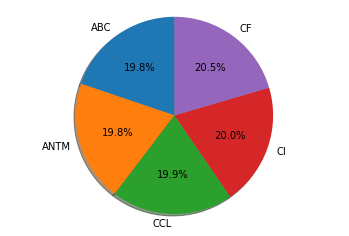

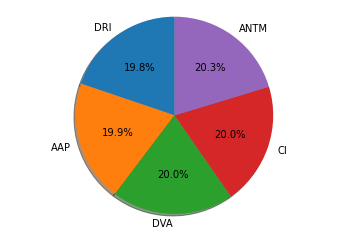

In [11]:
print(rCVAR_all_weight[1])
print(rCVAR_all_ticker[4])
print(rCVAR_all_ticker[5])
testplot.plot_pie(rCVAR_all_weight[4],rCVAR_all_ticker[4])
testplot.plot_pie(rCVAR_all_weight[5],rCVAR_all_ticker[5])

#Plot Class

In [10]:
class testplot(object):  
  ### Plot weight distribution as pie chart
  %matplotlib inline
  import matplotlib.pyplot as plt
  def plot_pie(weight, ticker):
    labels = df.index.values[ticker]

    sizes = weight

    # Creating plot 
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig.suptitle('portfolio weight')
    # ax1.pie(sizes_mvo, labels = labels_mvo) 
    # ax2.pie(sizes_cvar, labels = labels_cvar)
    # ax1.title.set_text('MVO')
    # ax2.title.set_text('CVaR')
    #explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

  ### Plot acutal and expected return
  %matplotlib inline
  import matplotlib.pyplot as plt
  import matplotlib.ticker as plticker
  def backtest_plot (date_list, all_port_act_ret, all_port_exp_ret):
    fig, ax = plt.subplots()
    loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.plot(date_list[:-3],all_port_act_ret[:-1],date_list[:-3],all_port_exp_ret[:-1],'b')
    # ax.set_xticklabels(['2010','2010','2012','2014','2016','2018','2020'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Return(%)')
    ax.set_title('Backtesting of Portfolio Return')
    ax.legend(['Actual Return','Expected Return'])

  ### Plot cumulative portfolio return
  %matplotlib inline
  import matplotlib.pyplot as plt
  def cum_plot (date_list, cum_ret_exp, cum_ret_act):
    fig, ax = plt.subplots()
    loc = plticker.MultipleLocator(base=90) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    # y = np.sin(x)
    ax.plot(date_list[:-2],np.asarray(cum_ret_exp)*100-100,date_list[:-2],np.asarray(cum_ret_act)*100-100)
    ax.set_xlabel('Date')
    ax.set_ylabel('Return (%)')
    ax.set_title('Cumulative Portfolio Return')
    ax.legend(['Cumulated Expected Return','Cumulated Actual Return'])
    # ax.set_xticklabels(['2010','2010','2012','2014', '2016','2018','2020'])

#Test Regime Switching

In [12]:

class Regime_test (object):
# card = 10
# regime_flag = 0
# regime_flag = 1
# model_flag = 0
# model_flag = 1
# model_flag = 2
# model_flag = 3
# model_flag = 4
# cost_flag = 0
# cost_flag = 1
# date = ['2010-10-15']
# price_table = df
  def cardinality (principal):
    if principal <= 10000:
      card = 5
    elif principal > 10000 and principal <= 100000:
      card = 5
    else: card = 12
    return card
  def choose_model (regime_flag):
    if regime_flag == 0:
      model_flag = 2
      cost_flag = 0
    else:
      model_flag = 1
      cost_flag = 0
    return model_flag, cost_flag
  def get_weight (mu, Q, card, price_table, date, old_weight, old_ticker, model_flag, cost_flag, target_return):
    opt_model = [[mvo,mvo_cost],[cvar,cvar_cost],[robust_cvar,robust_cvar_cost],
                [max_sharpe, max_sharpe_cost],[risk_parity, risk_parity_cost]]
    if model_flag == 1 or model_flag == 2:
      if cost_flag == 0:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q,card,price_table,date,target_return)
      else:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q, card, price_table, date, old_weight, old_ticker,target_return)
    else:
      if cost_flag == 0:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q,card)
      else:
        weight, ticker_index = opt_model[model_flag][cost_flag](mu,Q, card, old_weight, old_ticker)
    return weight, ticker_index

  def multiperiod (factors_return, excess_return, df, lookback, principal,target_return,regimes):
    weight = []
    ticker_index = []
    mu_all = []
    card = Regime_test.cardinality(principal)
    
    #model_flag, cost_flag = optimization.choose_model(regime_flag)
    #print(len(factors_return))
    if len(factors_return) % lookback != 0:
      factors_return = factors_return[:-int(len(factors_return) % lookback)]
    #print(len(factors_return))
    for i in range(int(len(factors_return)/lookback)):
      regime_flag = regimes[lookback*(i+1)]
      model_flag, cost_flag = Regime_test.choose_model(regime_flag)
      mu, Q = factors_fit.generate_factor(factors_return[0:(i+1)*lookback],excess_return[0:(i+1)*lookback])
      #print(len(Q))
      if i == 0:
        old_weight = np.zeros(card)
        old_ticker = np.arange(card)
      else:
        old_weight = weight[i-1]
        old_ticker = ticker_index[i-1]
      mu_all.append(mu)
      weight.append(Regime_test.get_weight(mu,Q,card, df, df.columns.values[(i+1)*lookback], old_weight, old_ticker, model_flag, cost_flag,target_return)[0])
      ticker_index.append(Regime_test.get_weight(mu,Q,card, df, df.columns.values[(i+1)*lookback], old_weight, old_ticker, model_flag, cost_flag,target_return)[1])
    return mu_all, weight, ticker_index
  
  def get_port_info (mu,Q,weight,ticker,date_list):
    all_weight = []
    all_ticker = []
    all_exp_return = []
    all_actual_return = []
    all_port_exp_ret = []
    all_port_act_ret = []
    for i in range(len(date_list)-2):
      cur_date = df.columns.values[date_list[i]]
      # exp_return = mu[ticker[i]]
      exp_return = mu[i][ticker[i]]
      actual_return = df.iloc[ticker[i],date_list[i+2]].values/df.iloc[ticker[i],date_list[i+1]].values
      port_exp_return = lookback*sum(weight[i]*exp_return)
      port_actual_return = sum(weight[i]*actual_return)-1
      all_weight.append(weight[i])
      all_ticker.append(ticker[i])
      all_exp_return.append(exp_return)
      all_actual_return.append(actual_return)
      all_port_exp_ret.append(port_exp_return)
      all_port_act_ret.append(port_actual_return)
    return all_weight, all_ticker, all_exp_return, all_actual_return, all_port_exp_ret, all_port_act_ret

  ### Calculate expected and actual cumulative return
  def cum_return (port_ret):
    cal_ret_list = []
    cum_ret_list = []
    for i in range(len(port_ret)):
      cal_ret_list.append(port_ret[i]+1)
    ret = 1
    for num in cal_ret_list:
      ret = ret*num
      cum_ret_list.append(ret)
    return cum_ret_list

  # calculate the mean difference between actual and expected return
  def mean_diff (act_ret,exp_ret):
    diff_list = np.asarray(act_ret) - np.asarray(exp_ret)
    return diff_list.mean()

  def sharpe_ratio (act_ret,exp_ret,rf):
    act_std = np.std(act_ret)
    exp_std = np.std(exp_ret)
    act_sr = (np.subtract(act_ret,rf))/act_std
    exp_sr = (np.subtract(exp_ret,rf))/exp_std
    return act_sr, exp_sr

  def get_cum_ret(date_list,lookback,target_return,regimes):
    cost_flag = 0
    mu_all, w, t = Regime_test.multiperiod (factors_return[:], excess_return[:], df=price_table, lookback = lookback, principal = 20000,target_return = target_return,regimes = regimes)
    #print(mu_all[1][t[1]])
    all_weight, all_ticker, all_exp_return, all_actual_return, all_port_exp_ret, all_port_act_ret = Regime_test.get_port_info (mu=mu_all,Q=None,weight=w,ticker=t,date_list=date_list)
    # mu_all[0][ticker[1]]
    # print(all_port_act_ret)
    cum_ret_exp = Regime_test.cum_return(all_port_exp_ret)
    cum_ret_act = Regime_test.cum_return(all_port_act_ret)
    return all_weight, all_ticker, cum_ret_exp,cum_ret_act

In [13]:
lookback = 26
target_return = 0.25*26/52
df = price_table
date_list = np.arange(0,751,lookback)
port_weight, port_ticker,portfolio_exp_ret,portfolio_act_ret=Regime_test.get_cum_ret(date_list,lookback,target_return, regimes)
# print("Robust CVAR DONE")
# CVAR_cum_ret_exp,CVAR_cum_ret_act=optimization_test.get_cum_ret(date_list,lookback, regimes)
# print("CVAR DONE")
# MVO_cum_ret_exp,MVO_cum_ret_act=optimization_test.get_cum_ret(date_list,lookback, regimes)
# print("MVO DONE")

In [14]:
print(len(regimes))

3776


In [15]:
#If always using CVaR:
CVAR_regimes = [1]*len(regimes)
cvar_port_weight, cvar_port_ticker, cvar_portfolio_exp_ret,cvar_portfolio_act_ret=Regime_test.get_cum_ret(date_list,lookback, target_return, CVAR_regimes)

In [16]:
#If always using RCVaR:
RCVAR_regimes = [0]*len(regimes)
Rcvar_port_weight, Rcvar_port_ticker, Rcvar_portfolio_exp_ret,Rcvar_portfolio_act_ret=Regime_test.get_cum_ret(date_list,lookback, target_return, CVAR_regimes)

In [17]:
portfolio_exp_ret.insert(0,1)
portfolio_act_ret.insert(0,1)
cvar_portfolio_act_ret.insert(0,1)
Rcvar_portfolio_act_ret.insert(0,1)

In [36]:

import yfinance as yf
start_date = '2005-09-30'
end_date = '2020-09-30'
data = yf.download("SPY", start=start_date, end=end_date)
print(data[:]['Adj Close'])
SPY_price = data[:]['Adj Close']
SPY_price = SPY_price[0:len(SPY_price):int(lookback*5)+1]
SPY_return = SPY_price.pct_change().dropna()
SPY_return = SPY_return.values.tolist()
SPY_act_return = []
base = 1
for i in range(len(SPY_return)):
  if i == 0:
    SPY_act_return.append(base)
  else:
    SPY_act_return.append(SPY_act_return[i-1]*(1+SPY_return[i]))

[*********************100%***********************]  1 of 1 completed
Date
2005-09-30     90.895706
2005-10-03     90.570633
2005-10-04     89.551186
2005-10-05     88.376595
2005-10-06     88.058876
                 ...    
2020-09-23    322.640015
2020-09-24    323.500000
2020-09-25    328.730011
2020-09-28    334.190002
2020-09-29    332.369995
Name: Adj Close, Length: 3775, dtype: float64


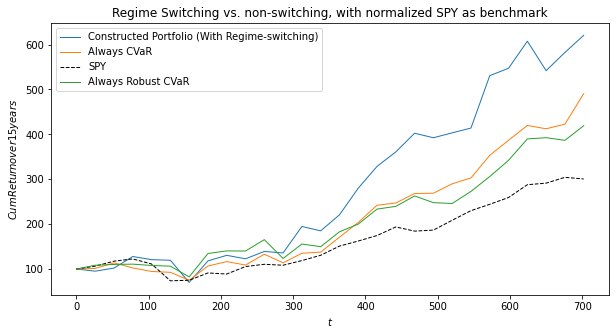

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(date_list[:-1], np.asarray(portfolio_act_ret[:])*100, linewidth=1)    #Using 95% VaR, 1000 times simulation, theta = 1.96
plt.plot(date_list[:-1], np.asarray(cvar_portfolio_act_ret)*100, linewidth=1)
# plt.plot(date_list[:-1], np.asarray(CVAR_cum_ret_act)*100, linewidth=1)     #Using 95% VaR, 1000 times simulation,
# plt.plot(date_list[:-1], np.asarray(MVO_cum_ret_act)*100, linewidth=1)
plt.plot(date_list[:-1],np.asarray(SPY_act_return)*100, 'k--',linewidth = 1)    #Use SPY, a S&P 500 tracking ETF as benchmark
plt.plot(date_list[:-1], np.asarray(Rcvar_portfolio_act_ret)*100, linewidth=1)
#plt.plot(date_list[:-1], np.asarray(Sharpe_cum_ret_act)*100, linewidth=1)
#plt.plot(date_list[:-1], np.asarray(RP_cum_ret_act)*100, linewidth=1)
plt.legend(['Constructed Portfolio (With Regime-switching)','Always CVaR','SPY','Always Robust CVaR'])
plt.xlabel('$t$')
plt.ylabel('$Cum Return over 15 years$')
plt.title('Regime Switching vs. non-switching, with normalized SPY as benchmark')
plt.show()